Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan Kozmos, ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve
etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from warnings import filterwarnings
filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# Görev 1: Metin Ön İşleme

## Adım1: amazon.xlsx verisini okutunuz.

In [2]:
df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


## Adım2: Review değişkeni üzerinde;
1. Tüm harfleri küçük harfe çeviriniz.
2. Noktalama işaretlerini çıkarınız.
3. Yorumlarda bulunan sayısal ifadeleri çıkarınız.
4. Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.
5. 1000'den az geçen kelimeleri veriden çıkarınız.
6. Lemmatization işlemini uygulayınız.

In [4]:
# 1)
df["Review"] = df["Review"].str.lower()
df["Review"].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object

In [5]:
# 2)
df["Review"] = df["Review"].str.replace("[^\w\s]", "", regex = True)
df["Review"].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windowsbr imagery ...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i cant believe the qua...
Name: Review, dtype: object

In [6]:
# 3)
df["Review"] = df["Review"].str.replace("\d", "", regex = True)
df["Review"].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windowsbr imagery ...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i cant believe the qua...
Name: Review, dtype: object

In [7]:
# 4)
sw = stopwords.words("english")
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"].head()

0                                                happy
1      good quality material however panels mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [8]:
# 5)
rw = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]

In [9]:
pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in rw))
df["Review"].head()

0                                                happy
1      good quality material however panels mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [10]:
# 6)
df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df["Review"].head()

0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

# Görev 2: Metin Görselleştirme


## Adım 1: Barplot görselleştirme işlemi için;
1. "Review" değişkeninin içerdiği kelimelerin frekanslarını hesaplayınız, tf olarak kaydediniz.
2. tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde
3. "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız.


In [11]:
# 1)
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf

,index,0
0,happy,196.0
1,good,535.0
2,quality,889.0
3,material,565.0
4,however,78.0
...,...,...
5259,relatively,1.0
5260,crispbr,1.0
5261,wfh,1.0
5262,gamers,1.0


In [12]:
# 2)
tf.columns = ["words", "tf"]

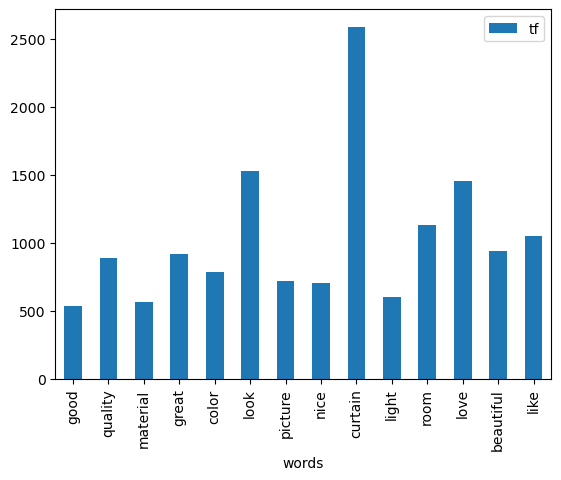

In [13]:
# 3)
tf[tf["tf"] > 500].plot.bar(x = "words", y = "tf")
plt.show()

## Adım2: WordCloud görselleştirme işlemi için;
1. "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz.
2. WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz.
3. Kaydettiğiniz wordcloud'u ilk adımda oluşturduğunuz string ile generate ediniz.
4. Görselleştirme adımlarını tamamlayınız. (figure, imshow, axis, show)

In [14]:
# 1)
text = " ".join([i for i in df["Review"]])
text

'happy good quality material however panel mismatched product fun bedroom windowsbr imagery bit stretched still funbr material lightweight sheer appreciate lo unico que gustaria e que sean un poco ma largas great bang buck cant believe quality material vibrant color eclectic style work beautifully tie together look different photo exactly looking heavy material great price ship fast looking picture thought curtain would thinner sheer nice thickness weight help insulate front window look absolutely perfect arrived quickly pleased purchase much whiter thought would wasnt really expecting wanting use curtain picture show rd set ambesonne curtain one set use spring summer one autumn set christmas winter durable color vibrant recommend curtain block view living room front door kitchendining area dont stress dish mess easily seen visitor put christmas light around really brightens everything private closed darkening point dont block light work fine night curtain sheer daytime labeled darkeni

In [15]:
type(text)

str

In [16]:
# 2,3)
wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(text)

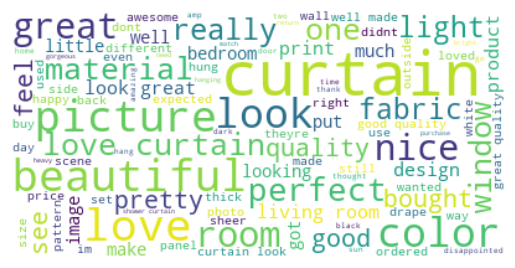

In [17]:
# 4)
plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Görev 3: Duygu Analizi

## Adım 1: Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz.

In [18]:
sia = SentimentIntensityAnalyzer()

## Adım2: SentimentIntensityAnalyzer nesnesi ile polarite puanlarını inceleyiniz;
1. "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız.
2. İncelenen ilk 10 gözlem için compund skorlarına göre filtreleyerek tekrar gözlemleyiniz.
3. 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz.
4. "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e ekleyiniz.


In [19]:
# 1)
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [20]:
# 2)
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.5719
1    0.4404
2    0.7184
3    0.0000
4    0.9042
5    0.0000
6    0.6249
7    0.9080
8    0.0000
9    0.7096
Name: Review, dtype: float64

In [21]:
# 3)
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [22]:
# 4) 
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Sentiment_Label"].head()

0    pos
1    pos
2    pos
3    neg
4    pos
Name: Sentiment_Label, dtype: object

In [23]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg    3.390791
pos    4.586692
Name: Star, dtype: float64

# Görev 4: Makine Öğrenmesine Hazırlık

## Adım 1: Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.


In [24]:
x_train, x_test, y_train, y_test = train_test_split(df["Review"], df["Sentiment_Label"], random_state = 42)

## Adım2: Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte;
1. TfidfVectorizer kullanarak bir nesne oluşturunuz.
2. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.
3. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

In [25]:
# 1)
tf_idf_vectorizer = TfidfVectorizer()

In [26]:
# 2)
tf_idf_vectorizer = tf_idf_vectorizer.fit(x_train)

In [27]:
# 3)
x_train_tf_idf_word = tf_idf_vectorizer.transform(x_train)
x_test_tf_idf_word = tf_idf_vectorizer.transform(x_test)

# Görev 5: Modelleme (Lojistik Regresyon)

## Adım 1: Lojistik regresyon modelini kurarak train dataları ile fit ediniz.


In [28]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, y_train)

## Adım 2: Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz;
1. Predict fonksiyonu ile test datasını tahmin ederek kaydediniz.
2. classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz.
3. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.


In [29]:
# 1)
y_pred = log_model.predict(x_test_tf_idf_word)

In [30]:
# 2)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8880969351389879

In [32]:
# 3)
cross_val_score(log_model, x_test_tf_idf_word, y_test, cv = 5).mean()

0.8546034570411795

## Adım 3: Veride bulunan yorumlardan ratgele seçerek modele sorulması;
1. sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere atayınız.2. Elde ettiğiniz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiriniz.
3. Vektörleştirdiğiniz örneklemi fit ve transform işlemlerini yaparak kaydediniz.
4. Kurmuş olduğunuz modele örneklemi vererek tahmin sonucunu kaydediniz.
5. Örneklemi ve tahmin sonucunu ekrana yazdırınız.

In [33]:
# 1)
random_review = pd.Series(df["Review"].sample(1).values)

In [34]:
# 2,3)
yeni_yorum = CountVectorizer().fit(x_train).transform(random_review)
yeni_yorum.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [35]:
# 4)
pred = log_model.predict(yeni_yorum)

In [36]:
# 5)
print(f"Örneklem: {random_review[0]} \nTahmin Sonucu: {pred}")

Örneklem: absolutely beautiful material heavy duty color super vibrant 
Tahmin Sonucu: ['pos']


In [37]:
random_review[0]

'absolutely beautiful material heavy duty color super vibrant'

# Görev 6: Modelleme (Random Forest)

## Adım 1: Random Forest modeli ile tahmin sonuçlarının gözlenmesi;
1. RandomForestClassifier modelini kurup fit ediniz.
2. Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.
3. Lojistik regresyon modeli ile sonuçları karşılaştırınız.

In [38]:
# 1)
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, y_train)

In [39]:
# 2)
cross_val_score(rf_model, x_test_tf_idf_word, y_test, cv = 5, n_jobs = -1).mean()

0.89165988815455

In [40]:
# 3) 
# Accuracy değerlerine baktığımızda random forest daha başarılı bir model.